<a href="https://colab.research.google.com/github/BioWar/NeRF-in-Colab/blob/main/NeRF_my_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Disclaimer:** Part of this code was taken from tiny_nerf.ipynb notebook and

official NeRF implementation by *bmild* on github.com/bmild/nerf .

### Required Imports and **Google Drive mount**

In [ ]:
from tqdm import tqdm_notebook as tqdm # Load progression, etc.
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, sys, imageio, time
%load_ext tensorboard
tf.compat.v1.enable_eager_execution()

In [ ]:
!apt-get install graphicsmagick-imagemagick-compat

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript graphicsmagick gsfonts
  libcupsfilters1 libcupsimage2 libgraphicsmagick-q16-3 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libwmf0.2-7 poppler-data
Suggested packages:
  fonts-noto ghostscript-x graphicsmagick-dbg libwmf0.2-7-gtk poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript graphicsmagick
  graphicsmagick-imagemagick-compat gsfonts libcupsfilters1 libcupsimage2
  libgraphicsmagick-q16-3 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libwmf0.2-7 po

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Load data in LLFF format

In [ ]:
########## Slightly modified version of LLFF data loading code 
##########  see https://github.com/Fyusion/LLFF for original

def _minify(basedir, factors=[], resolutions=[]):
    """ Function checked: ✔️
    Find basedir/images directory with original images.
    Check if directories for new images were already created
    Create them if they wasn't
    Copy original images in new directories
    Decrease their sizes
    Remove duplicates
    """
    needtoload = False
    for r in factors:
        # Check directory existence
        imgdir = os.path.join(basedir, 'images_{}'.format(r))
        if not os.path.exists(imgdir):
            needtoload = True
    for r in resolutions:
        imgdir = os.path.join(basedir, 'images_{}x{}'.format(r[1], r[0]))
        if not os.path.exists(imgdir):
            needtoload = True
    if not needtoload:
        # If all directories exists, return
        return
    
    from shutil import copy
    from subprocess import check_output
    
    imgdir = os.path.join(basedir, 'images') # basedir/images
    imgs = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir))] # list of files in basedir/images
    imgs = [f for f in imgs if any([f.endswith(ex) for ex in ['JPG', 'jpg', 'png', 'jpeg', 'PNG']])] # list of images in basedir/images
    imgdir_orig = imgdir
    
    wd = os.getcwd() # present working directory

    for r in factors + resolutions:
        if isinstance(r, int):
            name = 'images_{}'.format(r)
            resizearg = '{}%'.format(100./r)
        else:
            name = 'images_{}x{}'.format(r[1], r[0])
            resizearg = '{}x{}'.format(r[1], r[0])
        imgdir = os.path.join(basedir, name)
        # If directory exists than continue
        if os.path.exists(imgdir):
            continue
            
        print('Minifying', r, basedir)
        
        os.makedirs(imgdir) # Create directory with resized/factored images
        check_output('cp {}/* {}'.format(imgdir_orig, imgdir), shell=True) # Copy all images from basedir/images in basedir/images{x}
        
        ext = imgs[0].split('.')[-1] # Get images extension (png, jpg, jpeg, etc.)
        args = ' '.join(['mogrify', '-resize', resizearg, '-format', 'png', '*.{}'.format(ext)]) # resize images by some percentage
        print("Command to decrease image size:")
        print(args)
        os.chdir(imgdir)
        check_output(args, shell=True) # Execute command in args
        os.chdir(wd)
        
        if ext != 'png':
            check_output('rm {}/*.{}'.format(imgdir, ext), shell=True)
            print('Removed duplicates')
        print('Done')
            
        
        
        
def _load_data(basedir, factor=None, width=None, height=None, load_imgs=True):
    """ Function checked: ✔️
    Load poses file in basedir
    Resize images by some factor using _minify function
    Check if everything is correct
    Load images
    return images, poses, bds
    """
    poses_arr = np.load(os.path.join(basedir, 'poses_bounds.npy'))
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
    bds = poses_arr[:, -2:].transpose([1,0])
    
    # List images in basedir/images/
    img0 = [os.path.join(basedir, 'images', f) for f in sorted(os.listdir(os.path.join(basedir, 'images'))) \
            if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')][0]
    # Shape of images
    sh = imageio.imread(img0).shape
    
    sfx = ''
    
    # Rescale images by some factor (default 8)
    if factor is not None:
        sfx = '_{}'.format(factor)
        _minify(basedir, factors=[factor])
        factor = factor
    elif height is not None:
        factor = sh[0] / float(height)
        width = int(sh[1] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    elif width is not None:
        factor = sh[1] / float(width)
        height = int(sh[0] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    else:
        factor = 1
    
    # Check existence of directory with resized images
    imgdir = os.path.join(basedir, 'images' + sfx)
    if not os.path.exists(imgdir):
        print( imgdir, 'does not exist, returning' )
        return
    
    # Check if length of poses is identical to the amount of resized images
    imgfiles = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir)) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]
    if poses.shape[-1] != len(imgfiles):
        print( 'Mismatch between imgs {} and poses {} !!!!'.format(len(imgfiles), poses.shape[-1]) )
        return
    
    sh = imageio.imread(imgfiles[0]).shape # shape of the image
    poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
    poses[2, 4, :] = poses[2, 4, :] * 1./factor
    
    if not load_imgs:
        return poses, bds
    
    def imread(f):
        if f.endswith('png'):
            return imageio.imread(f, ignoregamma=True)
        else:
            return imageio.imread(f)
        
    # Normalize image values between 0. and 1.
    imgs = imgs = [imread(f)[...,:3]/255. for f in imgfiles]
    imgs = np.stack(imgs, -1) # Create numpy array of images
    
    print('Loaded image data', imgs.shape, poses[:,-1,0])
    return poses, bds, imgs

    
            
            
    

def normalize(x):
    return x / np.linalg.norm(x)

def viewmatrix(z, up, pos):
    vec2 = normalize(z)
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m

def ptstocam(pts, c2w):
    tt = np.matmul(c2w[:3,:3].T, (pts-c2w[:3,3])[...,np.newaxis])[...,0]
    return tt

def poses_avg(poses):

    hwf = poses[0, :3, -1:]

    center = poses[:, :3, 3].mean(0)
    vec2 = normalize(poses[:, :3, 2].sum(0))
    up = poses[:, :3, 1].sum(0)
    c2w = np.concatenate([viewmatrix(vec2, up, center), hwf], 1)
    
    return c2w



def render_path_spiral(c2w, up, rads, focal, zdelta, zrate, rots, N):
    render_poses = []
    rads = np.array(list(rads) + [1.])
    hwf = c2w[:,4:5]
    print(f"Render_path_spiral with: N = {N}")
    for theta in np.linspace(0., 2. * np.pi * rots, N+1)[:-1]:
        c = np.dot(c2w[:3,:4], np.array([np.cos(theta), -np.sin(theta), -np.sin(theta*zrate), 1.]) * rads) 
        z = normalize(c - np.dot(c2w[:3,:4], np.array([0,0,-focal, 1.])))
        render_poses.append(np.concatenate([viewmatrix(z, up, c), hwf], 1))
    print(f'Render_path_spiral with: render_poses len ={len(render_poses)}')
    return render_poses
    


def recenter_poses(poses):

    poses_ = poses+0
    bottom = np.reshape([0,0,0,1.], [1,4])
    c2w = poses_avg(poses)
    c2w = np.concatenate([c2w[:3,:4], bottom], -2)
    bottom = np.tile(np.reshape(bottom, [1,1,4]), [poses.shape[0],1,1])
    poses = np.concatenate([poses[:,:3,:4], bottom], -2)

    poses = np.linalg.inv(c2w) @ poses
    poses_[:,:3,:4] = poses[:,:3,:4]
    poses = poses_
    return poses


#####################


def spherify_poses(poses, bds):
    
    p34_to_44 = lambda p : np.concatenate([p, np.tile(np.reshape(np.eye(4)[-1,:], [1,1,4]), [p.shape[0], 1,1])], 1)
    
    rays_d = poses[:,:3,2:3]
    rays_o = poses[:,:3,3:4]

    def min_line_dist(rays_o, rays_d):
        A_i = np.eye(3) - rays_d * np.transpose(rays_d, [0,2,1])
        b_i = -A_i @ rays_o
        pt_mindist = np.squeeze(-np.linalg.inv((np.transpose(A_i, [0,2,1]) @ A_i).mean(0)) @ (b_i).mean(0))
        return pt_mindist

    pt_mindist = min_line_dist(rays_o, rays_d)
    
    center = pt_mindist
    up = (poses[:,:3,3] - center).mean(0)

    vec0 = normalize(up)
    vec1 = normalize(np.cross([.1,.2,.3], vec0))
    vec2 = normalize(np.cross(vec0, vec1))
    pos = center
    c2w = np.stack([vec1, vec2, vec0, pos], 1)

    poses_reset = np.linalg.inv(p34_to_44(c2w[None])) @ p34_to_44(poses[:,:3,:4])

    rad = np.sqrt(np.mean(np.sum(np.square(poses_reset[:,:3,3]), -1)))
    
    sc = 1./rad
    poses_reset[:,:3,3] *= sc
    bds *= sc
    rad *= sc
    
    centroid = np.mean(poses_reset[:,:3,3], 0)
    zh = centroid[2]
    radcircle = np.sqrt(rad**2-zh**2)
    new_poses = []
    
    for th in np.linspace(0.,2.*np.pi, 120):

        camorigin = np.array([radcircle * np.cos(th), radcircle * np.sin(th), zh])
        up = np.array([0,0,-1.])

        vec2 = normalize(camorigin)
        vec0 = normalize(np.cross(vec2, up))
        vec1 = normalize(np.cross(vec2, vec0))
        pos = camorigin
        p = np.stack([vec0, vec1, vec2, pos], 1)

        new_poses.append(p)

    new_poses = np.stack(new_poses, 0)
    
    new_poses = np.concatenate([new_poses, np.broadcast_to(poses[0,:3,-1:], new_poses[:,:3,-1:].shape)], -1)
    poses_reset = np.concatenate([poses_reset[:,:3,:4], np.broadcast_to(poses[0,:3,-1:], poses_reset[:,:3,-1:].shape)], -1)
    
    return poses_reset, new_poses, bds
    

def load_llff_data(basedir, factor=8, recenter=True, bd_factor=.75, spherify=False, path_zflat=False, N_views=120):
    

    poses, bds, imgs = _load_data(basedir, factor=factor) # factor=8 downsamples original imgs by 8x
    print('Loaded (basedir, bds.min(), bds.max()): ', basedir, bds.min(), bds.max())
    
    # Correct rotation matrix ordering and move variable dim to axis 0
    poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    imgs = np.moveaxis(imgs, -1, 0).astype(np.float32)
    images = imgs
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)
    
    # Rescale if bd_factor is provided
    sc = 1. if bd_factor is None else 1./(bds.min() * bd_factor)
    poses[:,:3,3] *= sc
    bds *= sc
    
    if recenter:
        poses = recenter_poses(poses)
        
    if spherify:
        poses, render_poses, bds = spherify_poses(poses, bds)

    else:
        
        c2w = poses_avg(poses)
        print('recentered (c2w.shape): ', c2w.shape)
        print(c2w[:3,:4])

        ## Get spiral
        # Get average pose
        up = normalize(poses[:, :3, 1].sum(0))

        # Find a reasonable "focus depth" for this dataset
        close_depth, inf_depth = bds.min()*.9, bds.max()*5.
        dt = .75
        mean_dz = 1./(((1.-dt)/close_depth + dt/inf_depth))
        focal = mean_dz

        # Get radii for spiral path
        shrink_factor = .8
        zdelta = close_depth * .2
        tt = poses[:,:3,3] # ptstocam(poses[:3,3,:].T, c2w).T
        rads = np.percentile(np.abs(tt), 90, 0)
        c2w_path = c2w
        # TODO Increase N_views
        # N_views = 120
        N_rots = 2
        if path_zflat:
#             zloc = np.percentile(tt, 10, 0)[2]
            zloc = -close_depth * .1
            c2w_path[:3,3] = c2w_path[:3,3] + zloc * c2w_path[:3,2]
            rads[2] = 0.
            N_rots = 1
            N_views/=2

        # Generate poses for spiral path
        render_poses = render_path_spiral(c2w_path, up, rads, focal, zdelta, zrate=.5, rots=N_rots, N=N_views)
        
        
    render_poses = np.array(render_poses).astype(np.float32)
    print(f"load_llff_data render_poses.shape = {render_poses.shape}")

    c2w = poses_avg(poses)
    print('Data (poses.shape, images.shape, bds.shape):')
    print(poses.shape, images.shape, bds.shape)
    
    dists = np.sum(np.square(c2w[:3,3] - poses[:,:3,3]), -1)
    i_test = np.argmin(dists)
    print('HOLDOUT view is (i_test): ', i_test)
    
    images = images.astype(np.float32)
    poses = poses.astype(np.float32)

    return images, poses, bds, render_poses, i_test

### Model methods

In [ ]:
def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches."""
    if chunk is None:
        return fn

    def ret(inputs):
        """Make predictions using model and batchified data"""
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret


def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """Prepares inputs and applies network 'fn'."""

    inputs_flat = tf.reshape(inputs, [-1, inputs.shape[-1]]) # Flat inputs, with shape (N, Channels)
    # print("run_network inputs_flat.shape = ", inputs_flat.shape)
    # print("run_network inputs_flat[0] = ", inputs_flat[0])

    embedded = embed_fn(inputs_flat) # Prepare flatted inputs with embeddings
    # print("run_network embedded.shape = ", embedded.shape)
    # print("run_network embedded[0] = ", embedded[0])
    # Check
    tf.debugging.check_numerics(inputs_flat, 'inputs_flat in run_network are NaN')
    tf.debugging.check_numerics(embedded, 'embedded in run_network are NaN')
    ########################
    if viewdirs is not None:
        input_dirs = tf.broadcast_to(viewdirs[:, None], inputs.shape)
        input_dirs_flat = tf.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = tf.concat([embedded, embedded_dirs], -1)
    ########################
    tf.debugging.check_numerics(input_dirs_flat, 'input_dirs_flat in run_network are NaN')
    tf.debugging.check_numerics(embedded, 'embedded with viewdirs in run_network are NaN')
    # tf.debugging.check_numerics(embedded, 'embedded 2 NaN {}'.format(k))
    
    # print("run_network viewdirs embedded.shape = ", embedded.shape)
    # print("run_network viewdirs embedded[0] = ", embedded[0])
    # Make predictions
    # tf.debugging.check_numerics(predictions, 'predictions NaN')
    outputs_flat = batchify(fn, netchunk)(embedded)
    # tf.debugging.check_numerics(outputs_flat, 'outputs_flat NaN')

    # print("run_network outputs_flat.shape = ", outputs_flat.shape)
    # print("run_network outputs_flat[0] = ", outputs_flat[0])
    # Reshape to output shape and return
    outputs = tf.reshape(outputs_flat, list(
        inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    return outputs


def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False):
    """Volumetric rendering.
    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      retraw: bool. If True, include model's raw, unprocessed predictions.
      lindisp: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_bkgd: bool. If True, assume a white background.
      raw_noise_std: ... (Add noise to input, I guess)
      verbose: bool. If True, print more debugging info.
    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disp_map: [num_rays]. Disparity map. 1 / depth.
      acc_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
      acc0: See acc_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each sample.
    """

    def raw2outputs(raw, z_vals, rays_d):
        """Transforms model's predictions to semantically meaningful values.
        Args:
          raw: [num_rays, num_samples along ray, 4]. Prediction from model.
          z_vals: [num_rays, num_samples along ray]. Integration time.
          rays_d: [num_rays, 3]. Direction of each ray.
        Returns:
          rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
          disp_map: [num_rays]. Disparity map. Inverse of depth map.
          acc_map: [num_rays]. Sum of weights along each ray.
          weights: [num_rays, num_samples]. Weights assigned to each sampled color.
          depth_map: [num_rays]. Estimated distance to object.
        """
        # Function for computing density from model prediction. This value is
        # strictly between [0, 1].
        # In raw2alpha "raw" = raw[..., 3], which means basically sigma
        def raw2alpha(raw, dists, act_fn=tf.nn.relu): return 1.0 - \
            tf.exp(-act_fn(raw) * dists)

        # Compute 'distance' (in time) between each integration time along a ray.
        dists = z_vals[..., 1:] - z_vals[..., :-1]

        # The 'distance' from the last integration time is infinity.
        dists = tf.concat(
            [dists, tf.broadcast_to([1e10], dists[..., :1].shape)],
            axis=-1)  # [N_rays, N_samples]

        # Multiply each distance by the norm of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        dists = dists * tf.linalg.norm(rays_d[..., None, :], axis=-1)

        # Extract RGB of each sample position along each ray.
        # print("raw2outputs raw[..., :3] = ", raw[..., :3])
        rgb = tf.math.sigmoid(raw[..., :3])  # [N_rays, N_samples, 3]
        # print("raw2outputs rgb = ", rgb)

        # Add noise to model's predictions for density. Can be used to 
        # regularize network during training (prevents floater artifacts).
        noise = 0.
        if raw_noise_std > 0.:
            noise = tf.random.normal(raw[..., 3].shape) * raw_noise_std

        # Predict density of each sample along each ray. Higher values imply
        # higher likelihood of being absorbed at this point.
        alpha = raw2alpha(raw[..., 3] + noise, dists)  # [N_rays, N_samples]

        # Compute weight for RGB of each sample along each ray.  A cumprod() is
        # used to express the idea of the ray not having reflected up to this
        # sample yet.
        # [N_rays, N_samples]
        weights = alpha * \
            tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True)
        # print("raw2outputs weights.shape = ", weights.shape)

        # Computed weighted color of each sample along each ray.
        rgb_map = tf.reduce_sum(
            weights[..., None] * rgb, axis=-2)  # [N_rays, 3]
        # print("raw2outputs rgb_map = ", rgb_map)

        # Estimated depth map is expected distance.
        depth_map = tf.reduce_sum(weights * z_vals, axis=-1)

        # Disparity map is inverse depth.
        disp_map = 1./tf.maximum(1e-10, depth_map /
                                 tf.reduce_sum(weights, axis=-1))

        # Sum of weights along each ray. This value is in [0, 1] up to numerical error.
        acc_map = tf.reduce_sum(weights, -1)

        # To composite onto a white background, use the accumulated alpha map.
        if white_bkgd:
            rgb_map = rgb_map + (1.-acc_map[..., None])

        return rgb_map, disp_map, acc_map, weights, depth_map

    ###############################
    # batch size
    N_rays = ray_batch.shape[0]
    # print("render_rays N_rays = ", N_rays)

    # Extract ray origin, direction.
    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]  # [N_rays, 3] each
    # print("render_rays rays_o[:2], rays_d[:2] = ", rays_o[:2], rays_d[:2])
    # Extract unit-normalized viewing direction.
    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] > 8 else None

    # Extract lower, upper bound for ray distance.
    bounds = tf.reshape(ray_batch[..., 6:8], [-1, 1, 2])
    near, far = bounds[..., 0], bounds[..., 1]  # [-1,1]
    # print("render_rays near, far = ", near, far)
    # Decide where to sample along each ray. Under the logic, all rays will be sampled at
    # the same times.
    t_vals = tf.linspace(0., 1., N_samples)
    if not lindisp:
        # Space integration times linearly between 'near' and 'far'. Same
        # integration points will be used for all rays.
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        # Sample linearly in inverse depth (disparity).
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))
    z_vals = tf.broadcast_to(z_vals, [N_rays, N_samples])
    tf.debugging.check_numerics(z_vals, message="render_rays, z_vals = nan")

    # Perturb sampling time along each ray.
    ##### Fix for a bug "TypeError: '>' not supported between instances of 'NoneType' and 'float'"
    perturb = 0
    #####
    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = tf.concat([mids, z_vals[..., -1:]], -1)
        lower = tf.concat([z_vals[..., :1], mids], -1)
        # stratified samples in those intervals
        t_rand = tf.random.uniform(z_vals.shape)
        z_vals = lower + (upper - lower) * t_rand

    # Points in space to evaluate model at.
    pts = rays_o[..., None, :] + rays_d[..., None, :] * \
        z_vals[..., :, None]  # [N_rays, N_samples, 3]

    # Evaluate model at each point.
    # print('render_rays pts.shape = ', pts.shape)
    # print('render_rays pts[0], pts[-1] = ', pts[0], pts[-1])
    # print("render_rays viewdirs = ", viewdirs)
    raw = network_query_fn(pts, viewdirs, network_fn)  # [N_rays, N_samples, 4]
    # print("render_rays raw.shape = ", raw.shape)
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(
        raw, z_vals, rays_d)

    if N_importance > 0:
        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map

        # Obtain additional integration times to evaluate based on the weights
        # assigned to colors in the coarse model.
        z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = sample_pdf(
            z_vals_mid, weights[..., 1:-1], N_importance, det=(perturb == 0.))
        z_samples = tf.stop_gradient(z_samples)

        # Obtain all points to evaluate color, density at.
        z_vals = tf.sort(tf.concat([z_vals, z_samples], -1), -1)
        pts = rays_o[..., None, :] + rays_d[..., None, :] * \
            z_vals[..., :, None]  # [N_rays, N_samples + N_importance, 3]

        # Make predictions with network_fine.
        run_fn = network_fn if network_fine is None else network_fine
        raw = network_query_fn(pts, viewdirs, run_fn)
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(
            raw, z_vals, rays_d)

    ret = {'rgb_map': rgb_map, 'disp_map': disp_map, 'acc_map': acc_map}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = tf.math.reduce_std(z_samples, -1)  # [N_rays]
    ########################
    for k in ret:
        tf.debugging.check_numerics(ret[k], 'output {}'.format(k))
    ########################
    return ret


def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM."""
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {k: tf.concat(all_ret[k], 0) for k in all_ret}
    return all_ret


def render(H, W, focal,
           chunk=1024*32, rays=None, c2w=None, ndc=True,
           near=0., far=1.,
           use_viewdirs=False, c2w_staticcam=None,
           **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """

    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, focal, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, focal, c2w_staticcam)

        # Make all directions unit magnitude.
        # shape: [batch_size, 3]
        viewdirs = viewdirs / tf.linalg.norm(viewdirs, axis=-1, keepdims=True)
        viewdirs = tf.cast(tf.reshape(viewdirs, [-1, 3]), dtype=tf.float32)

    sh = rays_d.shape  # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(
            H, W, focal, tf.cast(1., tf.float32), rays_o, rays_d)

    # Create ray batch
    rays_o = tf.cast(tf.reshape(rays_o, [-1, 3]), dtype=tf.float32)
    rays_d = tf.cast(tf.reshape(rays_d, [-1, 3]), dtype=tf.float32)
    near, far = near * \
        tf.ones_like(rays_d[..., :1]), far * tf.ones_like(rays_d[..., :1])

    # (ray origin, ray direction, min dist, max dist) for each ray
    rays = tf.concat([rays_o, rays_d, near, far], axis=-1)
    if use_viewdirs:
        # (ray origin, ray direction, min dist, max dist, normalized viewing direction)
        rays = tf.concat([rays, viewdirs], axis=-1)

    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = tf.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k: all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]


def render_path(render_poses, hwf, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor != 0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(render_poses):
        print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(
            H, W, focal, chunk=chunk, c2w=c2w[:3, :4], **render_kwargs)
        rgbs.append(rgb.numpy())
        disps.append(disp.numpy())
        if i == 0:
            print(rgb.shape, disp.shape)

        if gt_imgs is not None and render_factor == 0:
            p = -10. * np.log10(np.mean(np.square(rgb - gt_imgs[i])))
            print(p)

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)

    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps

### Ray helpers

In [ ]:
# Ray helpers

def get_rays(H, W, focal, c2w):
    """Function checked: ✔️
    Get ray origins, directions from a pinhole camera.
    i, j - meshgrid of raster space, with dimensions just like the image.shape,
           with 100 squares in length, and 100 squares in height
    dirs - directions of rays, with the beginning in camera origin, or the pinhole
           and the intersection in the middle of the pixel. Have x,y,z coordinates.
           Their amount equal to the amount of pixels.
    focal- focal length
    c2w  - transformation matrix, from "Camera space" to the "World space" 
    """
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32),
                       tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = tf.broadcast_to(c2w[:3, -1], tf.shape(rays_d))
    return rays_o, rays_d


def get_rays_np(H, W, focal, c2w):
    """Function checked: ✔️
    Get ray origins, directions from a pinhole camera.
    i, j - meshgrid of raster space, with dimensions just like the image.shape,
           with 100 squares in length, and 100 squares in height
    dirs - directions of rays, with the beginning in camera origin, or the pinhole
           and the intersection in the middle of the pixel. Have x,y,z coordinates.
           Their amount equal to the amount of pixels.
    focal- focal length
    c2w  - transformation matrix, from "Camera space" to the "World space" 
    """
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    return rays_o, rays_d


def ndc_rays(H, W, focal, near, rays_o, rays_d):
    """Normalized device coordinate rays. Function checked: ✔️
    https://github.com/bmild/nerf/files/4451808/ndc_derivation.pdf
    Space such that the canvas is a cube with sides [-1, 1] in each axis.
    Args:
      H: int. Height in pixels.
      W: int. Width in pixels.
      focal: float. Focal length of pinhole camera.
      near: float or array of shape[batch_size]. Near depth bound for the scene.
      rays_o: array of shape [batch_size, 3]. Camera origin.
      rays_d: array of shape [batch_size, 3]. Ray direction.
    Returns:
      rays_o: array of shape [batch_size, 3]. Camera origin in NDC.
      rays_d: array of shape [batch_size, 3]. Ray direction in NDC.
    """
    # Shift ray origins to near plane
    t = -(near + rays_o[..., 2]) / rays_d[..., 2]
    rays_o = rays_o + t[..., None] * rays_d

    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[..., 0] / rays_o[..., 2]
    o1 = -1./(H/(2.*focal)) * rays_o[..., 1] / rays_o[..., 2]
    o2 = 1. + 2. * near / rays_o[..., 2]

    d0 = -1./(W/(2.*focal)) * \
        (rays_d[..., 0]/rays_d[..., 2] - rays_o[..., 0]/rays_o[..., 2])
    d1 = -1./(H/(2.*focal)) * \
        (rays_d[..., 1]/rays_d[..., 2] - rays_o[..., 1]/rays_o[..., 2])
    d2 = -2. * near / rays_o[..., 2]

    rays_o = tf.stack([o0, o1, o2], -1)
    rays_d = tf.stack([d0, d1, d2], -1)

    return rays_o, rays_d


# Hierarchical sampling helper

def sample_pdf(bins, weights, N_samples, det=False):
    """
    https://arxiv.org/pdf/2003.08934.pdf Section 5.2
    """
    # Get pdf
    weights += 1e-5  # prevent nans
    pdf = weights / tf.reduce_sum(weights, -1, keepdims=True)
    cdf = tf.cumsum(pdf, -1)
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], -1)

    # Take uniform samples
    if det:
        u = tf.linspace(0., 1., N_samples)
        u = tf.broadcast_to(u, list(cdf.shape[:-1]) + [N_samples])
    else:
        u = tf.random.uniform(list(cdf.shape[:-1]) + [N_samples])

    # Invert CDF
    inds = tf.searchsorted(cdf, u, side='right')
    below = tf.maximum(0, inds-1)
    above = tf.minimum(cdf.shape[-1]-1, inds)
    inds_g = tf.stack([below, above], -1)
    cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)

    denom = (cdf_g[..., 1]-cdf_g[..., 0])
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
    t = (u-cdf_g[..., 0])/denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1]-bins_g[..., 0])

    return samples

### Model Creation

In [ ]:
class Embedder:
    """ Embedder class created to make embeddings of the input data.
    One for x,y,z and another one for Theta, phi. With different final
    dimensions."""
    def __init__(self, **kwargs):

        self.kwargs = kwargs
        self.create_embedding_fn()

    def create_embedding_fn(self):

        embed_fns = []
        d = self.kwargs['input_dims'] # self-explanatory
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x: x)
            out_dim += d

        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']

        if self.kwargs['log_sampling']:
            freq_bands = 2.**tf.linspace(0., max_freq, N_freqs)
        else:
            freq_bands = tf.linspace(2.**0., 2.**max_freq, N_freqs)

        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn,
                                 freq=freq: p_fn(x * freq))
                out_dim += d

        self.embed_fns = embed_fns
        self.out_dim = out_dim

    def embed(self, inputs):
        return tf.concat([fn(inputs) for fn in self.embed_fns], -1)


def get_embedder(multires, i=0):

    if i == -1:
        return tf.identity, 3

    embed_kwargs = {
        'include_input': True,
        'input_dims': 3,
        'max_freq_log2': multires-1,
        'num_freqs': multires,
        'log_sampling': True,
        'periodic_fns': [tf.math.sin, tf.math.cos],
    }

    embedder_obj = Embedder(**embed_kwargs)
    def embed(x, eo=embedder_obj): return eo.embed(x)
    return embed, embedder_obj.out_dim

In [ ]:
def init_nerf_model(D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=False):
    """
    Creates NeRF Model which consists of Dense layers, with concatenation of
    input data in the middle of the network
    """
    relu = tf.keras.layers.ReLU()
    def dense(W, act=relu): return tf.keras.layers.Dense(W, activation=act)

    print('MODEL input_ch, input_ch_views, type(input_ch), type(input_ch_views), use_viewdirs',\
          input_ch, input_ch_views, type(input_ch), type(input_ch_views),\
          use_viewdirs)
    
    input_ch = int(input_ch)
    input_ch_views = int(input_ch_views)

    inputs = tf.keras.Input(shape=(input_ch + input_ch_views))
    inputs_pts, inputs_views = tf.split(inputs, [input_ch, input_ch_views], -1)
    inputs_pts.set_shape([None, input_ch])
    inputs_views.set_shape([None, input_ch_views])

    print("inputs.shape, inputs_pts.shape, inputs_views.shape: ",\
          inputs.shape, inputs_pts.shape, inputs_views.shape)
    
    outputs = inputs_pts
    
    for i in range(D):
        outputs = dense(W)(outputs)
        if i in skips:
            outputs = tf.concat([inputs_pts, outputs], -1)

    if use_viewdirs:
        alpha_out = dense(1, act=None)(outputs)
        bottleneck = dense(256, act=None)(outputs)
        inputs_viewdirs = tf.concat(
            [bottleneck, inputs_views], -1)  # concat viewdirs
        outputs = inputs_viewdirs
        # The supplement to the paper states there are 4 hidden layers here, but this is an error since
        # the experiments were actually run with 1 hidden layer, so we will leave it as 1.
        for i in range(1):
            outputs = dense(W//2)(outputs)
        outputs = dense(3, act=None)(outputs)
        outputs = tf.concat([outputs, alpha_out], -1)
    else:
        outputs = dense(output_ch, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def init_fast_nerf_model(D_pos=8, D_view=4, W_pos=384, W_view=128, input_ch=3, input_ch_views=3):
    relu = tf.keras.layers.ReLU()
    def dense(W, act=relu): return tf.keras.layers.Dense(W, activation=act)
    
    input_ch = int(input_ch)
    input_ch_views = int(input_ch_views)

    inputs = tf.keras.Input(shape=(input_ch + input_ch_views))
    inputs_pts, inputs_views = tf.split(inputs, [input_ch, input_ch_views], -1)
    inputs_pts.set_shape([None, input_ch])
    inputs_views.set_shape([None, input_ch_views])

    outputs_pts = inputs_pts
    outputs_views = inputs_views

    for i in range(D_pos):
      outputs_pts = dense(W_pos)(outputs_pts)
    for j in range(D_view):
      outputs_views = dense(W_view)(outputs_views)

    alpha_out    = dense(1, act=None)(outputs_pts)
    outputs_uvw  = dense(3, act=None)(outputs_pts)
    outputs_beta = dense(1, act=None)(outputs_views)

    outputs = tf.concat([outputs_uvw, outputs_beta, alpha_out], -1)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def create_fast_nerf(args):

    embed_fn, input_ch = get_embedder(args.multires, args.i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(
            args.multires_views, args.i_embed)
    output_ch = 4
    skips = [4]
    # Create "coarse" model
    # D_pos=8, D_view=4, W_pos=384, W_view=128, input_ch=3, input_ch_views=3
    model = init_fast_nerf_model(
        D_pos=args.netdepth_pos, D_view=args.netdepth_view,
        W_pos=args.netwidth_pos, W_view=args.netwidth_view,
        input_ch=input_ch, input_ch_views=input_ch_views)
    grad_vars = model.trainable_variables
    models = {'model': model}

    model_fine = None
    if args.N_importance > 0:
        # Create "fine" model. It will receive (probably) inputs from "coarse model"
        # to improve predictions
        model_fine = init_fast_nerf_model(
          D_pos=args.netdepth_fine_pos, D_view=args.netdepth_fine_view,
          W_pos=args.netwidth_fine_pos, W_view=args.netwidth_fine_view,
          input_ch=input_ch, input_ch_views=input_ch_views)
        grad_vars += model_fine.trainable_variables
        models['model_fine'] = model_fine

    def network_query_fn(inputs, viewdirs, network_fn): return run_network(
        inputs, viewdirs, network_fn,
        embed_fn=embed_fn,
        embeddirs_fn=embeddirs_fn,
        netchunk=args.netchunk)

    render_kwargs_train = {
        'network_query_fn': network_query_fn,
        'perturb': args.perturb,
        'N_importance': args.N_importance,
        'network_fine': model_fine,
        'N_samples': args.N_samples,
        'network_fn': model,
        'use_viewdirs': args.use_viewdirs,
        'white_bkgd': args.white_bkgd,
        'raw_noise_std': args.raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {
        k: render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = 0.
    render_kwargs_test['raw_noise_std'] = 0.

    start = 0
    basedir = args.basedir
    expname = args.expname

    if args.ft_path is not None and args.ft_path != 'None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if
                 ('model_' in f and 'fine' not in f and 'optimizer' not in f)]
    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ft_weights = ckpts[-1]
        print('Reloading from', ft_weights)
        model.set_weights(np.load(ft_weights, allow_pickle=True))
        start = int(ft_weights[-10:-4]) + 1
        print('Resetting step to', start)

        if model_fine is not None:
            ft_weights_fine = '{}_fine_{}'.format(
                ft_weights[:-11], ft_weights[-10:])
            print('Reloading fine from', ft_weights_fine)
            model_fine.set_weights(np.load(ft_weights_fine, allow_pickle=True))

    return render_kwargs_train, render_kwargs_test, start, grad_vars, models

In [ ]:
def create_nerf(args):
    """Instantiate NeRF's MLP model."""

    embed_fn, input_ch = get_embedder(args.multires, args.i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(
            args.multires_views, args.i_embed)
    output_ch = 4
    skips = [4]
    # Create "coarse" model
    model = init_nerf_model(
        D=args.netdepth, W=args.netwidth,
        input_ch=input_ch, output_ch=output_ch, skips=skips,
        input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)
    grad_vars = model.trainable_variables
    models = {'model': model}

    model_fine = None
    if args.N_importance > 0:
        # Create "fine" model. It will receive (probably) inputs from "coarse model"
        # to improve predictions
        model_fine = init_nerf_model(
            D=args.netdepth_fine, W=args.netwidth_fine,
            input_ch=input_ch, output_ch=output_ch, skips=skips,
            input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)
        grad_vars += model_fine.trainable_variables
        models['model_fine'] = model_fine

    def network_query_fn(inputs, viewdirs, network_fn): return run_network(
        inputs, viewdirs, network_fn,
        embed_fn=embed_fn,
        embeddirs_fn=embeddirs_fn,
        netchunk=args.netchunk)

    render_kwargs_train = {
        'network_query_fn': network_query_fn,
        'perturb': args.perturb,
        'N_importance': args.N_importance,
        'network_fine': model_fine,
        'N_samples': args.N_samples,
        'network_fn': model,
        'use_viewdirs': args.use_viewdirs,
        'white_bkgd': args.white_bkgd,
        'raw_noise_std': args.raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {
        k: render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = 0.
    render_kwargs_test['raw_noise_std'] = 0.

    start = 0
    basedir = args.basedir
    expname = args.expname

    if args.ft_path is not None and args.ft_path != 'None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if
                 ('model_' in f and 'fine' not in f and 'optimizer' not in f)]
    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ft_weights = ckpts[-1]
        print('Reloading from', ft_weights)
        model.set_weights(np.load(ft_weights, allow_pickle=True))
        start = int(ft_weights[-10:-4]) + 1
        print('Resetting step to', start)

        if model_fine is not None:
            ft_weights_fine = '{}_fine_{}'.format(
                ft_weights[:-11], ft_weights[-10:])
            print('Reloading fine from', ft_weights_fine)
            model_fine.set_weights(np.load(ft_weights_fine, allow_pickle=True))

    return render_kwargs_train, render_kwargs_test, start, grad_vars, models

### Actual Loading of data

In [ ]:
# Useless construct to replace original args return by argparse module and users input

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args_create_nerf = {'multires': 10, # type=int, default=10, help='log2 of max freq for positional encoding (3D location)'
                    'i_embed': 0, # type=int, default=0, help='set 0 for default positional encoding, -1 for none'
                    'use_viewdirs': True, # action='store_true', help='use full 5D input instead of 3D'
                    'multires_views': 4, #  type=int, default=4, help='log2 of max freq for positional encoding (2D direction)'
                    'netdepth': 8, # type=int, default=8, help='layers in network'
                    'netwidth': 256, # type=int, default=256, help='channels per layer'
                    'N_importance': 128, # type=int, default=0, help='number of additional fine samples per ray'
                    'netdepth_fine': 8, # type=int, default=8, help='layers in fine network'
                    'netwidth_fine': 256, # type=int, default=256, help='channels per layer in fine network'
                    'dataset_type': 'llff', # type=str, default='llff', help='options: llff / blender / deepvoxels
                    'factor': 8,
                    'spherify': False,
                    'llffhold': 8,
                    'datadir': "/content/drive/MyDrive/Dataset/NeRF_Train",
                    'netchunk': 1024*64, # type=int, default=1024*64, help='number of pts sent through network in parallel, decrease if running out of memory'
                    'N_samples': 128, # type=int, default=64, help='number of coarse samples per ray'
                    'white_bkgd': False, # action='store_true', help='set to render synthetic data on a white bkgd (always use for dvoxels)'
                    'raw_noise_std': 1e0, # type=float, default=0., help='std dev of noise added to regularize sigma_a output, 1e0 recommended'
                    'no_ndc': False, # action='store_true', help='do not use normalized device coordinates (set for non-forward facing scenes)'
                    'lindisp': True, # action='store_true', help='sampling linearly in disparity rather than depth'
                    'basedir':  "/content/drive/MyDrive/Models/NeRF/logs", # type=str, default='./logs/', help='where to store ckpts and logs'
                    'expname': "Train", # type=str, help='experiment name'
                    'ft_path': None, # type=str, default=None, help='specific weights npy file to reload for coarse network'
                    'no_reload': False, # action='store_true', help='do not reload weights from saved ckpt'
                    'render_test': True, # action='store_true', help='render the test set instead of render_poses path'
                    'config': False, # is_config_file=True, help='config file path'
                    'render_only': False,
                    'lrate': 5e-5,
                    'lrate_decay': 0,
                    'N_rand': 1024, # type=int, default=32*32*4, help='batch size (number of random rays per gradient step)'
                    'no_batching': True,
                    'N_iters': 200010,
                    'perturb': 0,
                    'epsilon': 1e-07,
                    'i_print': 1000,
                    'i_img': 1000,
                    'i_weights': 1000,
                    'chunk': 1024*32,
                    'N_views': 240
                    }
args_create_nerf = dotdict(args_create_nerf)

Loaded image data (375, 500, 3, 25) [375.         500.         362.90451445]
Loaded (basedir, bds.min(), bds.max()):  /content/drive/MyDrive/Dataset/NeRF_Train 2.561864831080393 55.9432997509579
recentered (c2w.shape):  (3, 5)
[[ 1.0000000e+00  1.1716409e-09 -2.5613707e-08 -6.6757202e-08]
 [-1.1716407e-09  1.0000000e+00  7.1149184e-09 -2.3841857e-09]
 [ 2.5613705e-08 -7.1149184e-09  1.0000000e+00 -4.2915346e-08]]
Render_path_spiral with: N = 120
Render_path_spiral with: render_poses len =120
load_llff_data render_poses.shape = (120, 3, 5)
Data (poses.shape, images.shape, bds.shape):
(25, 3, 5) (25, 375, 500, 3) (25, 2)
HOLDOUT view is (i_test):  11
Loaded llff (25, 375, 500, 3) (120, 3, 5) [375.     500.     362.9045] /content/drive/MyDrive/Dataset/NeRF_Train
Auto LLFF holdout, 8
DEFINING BOUNDS
NEAR FAR 0.0 1.0
Images.shape =  (25, 375, 500, 3)
Poses.shape =  (25, 3, 4)
bds.shape =  (25, 2)
render_poses.shape =  (120, 3, 5)
i_test.shape =  (4,)
Poses[0] =  [[ 0.58120096 -0.06399601 -0

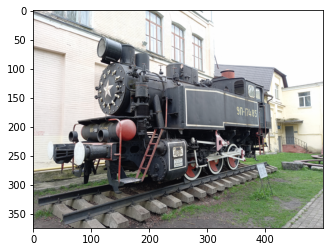

MODEL input_ch, input_ch_views, type(input_ch), type(input_ch_views), use_viewdirs 63 27 <class 'int'> <class 'int'> True
inputs.shape, inputs_pts.shape, inputs_views.shape:  (None, 90) (None, 63) (None, 27)
MODEL input_ch, input_ch_views, type(input_ch), type(input_ch_views), use_viewdirs 63 27 <class 'int'> <class 'int'> True
inputs.shape, inputs_pts.shape, inputs_views.shape:  (None, 90) (None, 63) (None, 27)
Found ckpts ['/content/drive/MyDrive/Models/NeRF/logs/Train/model_000000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Train/model_001000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Train/model_002000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Train/model_003000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Train/model_004000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Train/model_005000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Train/model_006000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Train/model_007000.npy', '/content/drive/MyDrive/Models/NeRF/logs/Tr

In [ ]:
images, poses, bds, render_poses, i_test = load_llff_data(args_create_nerf.datadir,
                                                          args_create_nerf.factor,
                                                          recenter=True,
                                                          bd_factor=.75,
                                                          spherify=args_create_nerf.spherify,
                                                          N_views=args_create_nerf.N_views)

hwf = poses[0, :3, -1]
poses = poses[:, :3, :4]
print('Loaded llff', images.shape,
      render_poses.shape, hwf, args_create_nerf.datadir)
if not isinstance(i_test, list):
    i_test = [i_test]

if args_create_nerf.llffhold > 0:
    print('Auto LLFF holdout,', args_create_nerf.llffhold)
    i_test = np.arange(images.shape[0])[::args_create_nerf.llffhold]

i_val = i_test
i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                    (i not in i_test and i not in i_val)])

print('DEFINING BOUNDS')
if args_create_nerf.no_ndc:
    near = tf.reduce_min(bds) * .9
    far = tf.reduce_max(bds) * 1.
else:
    near = 0.
    far = 1.
print('NEAR FAR', near, far)

# images, poses, bds, render_poses, i_test
print("Images.shape = ", images.shape)
print("Poses.shape = ", poses.shape)
print("bds.shape = ", bds.shape)
print("render_poses.shape = ", render_poses.shape)
print("i_test.shape = ", i_test.shape)

print("Poses[0] = ", poses[0])
print("bds[0] = ", bds[0])
print("i_test = ", i_test)

import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

if args_create_nerf.render_test:
    render_poses = np.array(poses[i_test])

basedir = args_create_nerf.basedir
expname = args_create_nerf.expname 

os.makedirs(os.path.join(basedir, expname), exist_ok=True)
f = os.path.join(basedir, expname, 'args_create_nerf.txt')
with open(f, 'w') as file:
    for arg in sorted(args_create_nerf.items()):
        file.write('{} = {}\n'.format(arg[0], arg[1]))

render_kwargs_train, render_kwargs_test, start, grad_vars, models = create_nerf(args_create_nerf)

print("type(render_kwargs_train)", type(render_kwargs_train))
for k, v in render_kwargs_train.items():
  print("    --", k, " = ", v)
print("type(render_kwargs_test)", type(render_kwargs_test))
for k, v in render_kwargs_test.items():
  print("    --", k, " = ", v)
print("type(start)", type(start))
print("start = ", start)
print("type(grad_vars)", type(grad_vars))
print("grad_vars = ", len(grad_vars))
print("grad_vars[0] = ", grad_vars[0])
print("grad_vars[0].shape = ", grad_vars[0].shape)
print("type(models)", type(models))
for k, v in models.items():
  print("    --", k, " = ", v)

bds_dict = {
    'near': tf.cast(near, tf.float32),
    'far': tf.cast(far, tf.float32),
}
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

# Short circuit if only rendering out from trained model
if args_create_nerf.render_only:
    print('RENDER ONLY')
    if args_create_nerf.render_test:
        # render_test switches to test poses
        images = images[i_test]
    else:
        # Default is smoother render_poses path
        images = None

    testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format(
        'test' if args_create_nerf.render_test else 'path', start))
    os.makedirs(testsavedir, exist_ok=True)
    print('test poses shape', render_poses.shape)

    rgbs, _ = render_path(render_poses, hwf, chunk, render_kwargs_test,
                          gt_imgs=images, savedir=testsavedir, render_factor=args_create_nerf.render_factor)
    print('Done rendering', testsavedir)
    imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'),
                      to8b(rgbs), fps=30, quality=8)
    
# optimizer = tf.keras.optimizers.Adam(args_create_nerf.lrate)
# models['optimizer'] = optimizer

lrate = args_create_nerf.lrate
if args_create_nerf.lrate_decay > 0:
    lrate = tf.keras.optimizers.schedules.ExponentialDecay(lrate,
                                                            decay_steps=args_create_nerf.lrate_decay * 1000, decay_rate=0.1)
optimizer = tf.keras.optimizers.Adam(lrate, epsilon=args_create_nerf.epsilon)
models['optimizer'] = optimizer

global_step = tf.compat.v1.train.get_or_create_global_step()
global_step.assign(start)

N_rand = args_create_nerf.N_rand # type=int, default=32*32*4, help='batch size (number of random rays per gradient step)'
no_batching = args_create_nerf.no_batching
use_batching = not no_batching 

N_iters = args_create_nerf.N_iters
print('TRAIN views are (idx. of training images): ', i_train)
print('TEST views are (idx. of test images): ', i_test)
print('VAL views are (idx. of val images): ', i_val)
print("basedir = ", basedir)

import imageio
import json

# Misc utils

def img2mse(x, y): 
  """Mean Squere Error of image and prediction"""
  return tf.reduce_mean(tf.square(x - y))

def mse2psnr(x): 
  """PSNR calculation"""
  return -10.*tf.math.log(x)/tf.math.log(10.)

def to8b(x): 
  """Back to normal pixel values in range 0 to 255 from range 0. to 1."""
  return (255*np.clip(x, 0, 1)).astype(np.uint8)

### Train

In [ ]:
# logdir = basedir + 'logs' + expname
# %tensorboard --logdir logdir

In [ ]:
# The problem in Embeddings in run_network (CHECK IT)

### Simplest fucking training loop possible
precrop_iters = 0 # type=int, default=0, help='number of steps to train on central crops'
precrop_frac = 0.5 # type=float, default=.5, help='fraction of img taken for central crops'

# Summary writers
writer = tf.summary.create_file_writer(
    os.path.join(basedir, 'summaries', expname))
# writer.set_as_default()

with writer.as_default():
  for i in range(start, N_iters):
    time0 = time.time()
    ###############################
    img_i = np.random.choice(i_train)
    target = images[img_i]
    pose = poses[img_i, :3, :4]

    if N_rand is not None:
        # print("Creating batch with N_rand = ", N_rand)
        rays_o, rays_d = get_rays(H, W, focal, pose)
        coords = tf.stack(tf.meshgrid(tf.range(H), tf.range(W), indexing='ij'), -1)
        coords = tf.reshape(coords, [-1, 2])
        select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)
        select_inds = tf.gather_nd(coords, select_inds[:, tf.newaxis])
        rays_o = tf.gather_nd(rays_o, select_inds)
        rays_d = tf.gather_nd(rays_d, select_inds)
        batch_rays = tf.stack([rays_o, rays_d], 0)
        target_s = tf.gather_nd(target, select_inds)
    ###############################

    with tf.GradientTape() as tape:
      # Make predictions for color, disparity, accumulated opacity.
      # try:
      rgb, disp, acc, extras = render(
          H, W, focal, chunk=args_create_nerf.chunk, rays=batch_rays,
          verbose=i < 10, retraw=True, **render_kwargs_train)
      # except:
      #   continue
      img_loss = img2mse(rgb, target_s)
      trans = extras['raw'][..., -1]
      loss = img_loss
      psnr = mse2psnr(img_loss)

      # Add MSE loss for coarse-grained model
      if 'rgb0' in extras:
          img_loss0 = img2mse(extras['rgb0'], target_s)
          loss += img_loss0
          psnr0 = mse2psnr(img_loss0)

    gradients = tape.gradient(loss, grad_vars)
    optimizer.apply_gradients(zip(gradients, grad_vars))

    dt = time.time() - time0

    def save_weights(net, prefix, i):
      path = os.path.join(basedir, expname, '{}_{:06d}.npy'.format(prefix, i))
      np.save(path, net.get_weights())
      print('saved_weights at ', path)

    if i % args_create_nerf.i_weights == 0:
      for k in models:
        save_weights(models[k], k, i)
    
    if i % args_create_nerf.i_print == 0 or i < 10:
      print(expname, i, psnr.numpy(), loss.numpy(), global_step.numpy())
      print('iter time {:.05f}'.format(dt))
      tf.summary.scalar('loss', loss, step=i)
      tf.summary.scalar('psnr', psnr, step=i)
      if args_create_nerf.N_importance > 0:
        tf.summary.scalar('psnr0', psnr0, step=i)

      if i % args_create_nerf.i_img == 0:
        img_i = np.random.choice(i_val)
        target = images[img_i]
        pose = poses[img_i, :3, :4]

        try:
          rgb, disp, acc, extras = render(H, W, focal, chunk=args_create_nerf.chunk,
                                        c2w=pose, **render_kwargs_test)
        except:
          continue
        psnr = mse2psnr(img2mse(rgb, target))

        testimgdir = os.path.join(basedir, expname, 'tboard_val_imgs')
        if i==0:
          os.makedirs(testimgdir, exist_ok=True)
        imageio.imwrite(os.path.join(testimgdir, '{:06d}.png'.format(i)), to8b(rgb))

        tf.summary.image('rgb', to8b(rgb)[tf.newaxis], step=i)
        tf.summary.image('disp', disp[tf.newaxis, ..., tf.newaxis], step=i)
        tf.summary.image('acc', acc[tf.newaxis, ..., tf.newaxis], step=i)
        tf.summary.scalar('psnr_holdout', psnr, step=i)
        tf.summary.image('rgb_holdout', target[tf.newaxis], step=i)

        if args_create_nerf.N_importance > 0:
          tf.summary.image('rgb0', to8b(extras['rgb0'])[tf.newaxis], step=i)
          tf.summary.image('disp0', extras['disp0'][tf.newaxis, ..., tf.newaxis], step=i)
          tf.summary.image('z_std', extras['z_std'][tf.newaxis, ..., tf.newaxis], step=i)

    writer.flush()
    global_step.assign_add(1)
    print(f"Epoch {i+1}/{N_iters}(time={dt}): loss:{loss}, PSNR:{psnr};")

Epoch 100002/200010(time=0.4614262580871582): loss:0.0031241485849022865, PSNR:28.371044158935547;
Epoch 100003/200010(time=0.3466908931732178): loss:0.0041826581582427025, PSNR:27.000930786132812;
Epoch 100004/200010(time=0.3420829772949219): loss:0.0051748864352703094, PSNR:25.90009117126465;
Epoch 100005/200010(time=0.34141111373901367): loss:0.004867753013968468, PSNR:26.238759994506836;
Epoch 100006/200010(time=0.34015941619873047): loss:0.00502709299325943, PSNR:25.973299026489258;
Epoch 100007/200010(time=0.3436243534088135): loss:0.004287487827241421, PSNR:26.908823013305664;
Epoch 100008/200010(time=0.3522641658782959): loss:0.0032310779206454754, PSNR:28.089786529541016;
Epoch 100009/200010(time=0.3393094539642334): loss:0.0036597459111362696, PSNR:27.67961883544922;
Epoch 100010/200010(time=0.34226346015930176): loss:0.0044242870062589645, PSNR:26.6170597076416;
Epoch 100011/200010(time=0.33992671966552734): loss:0.0038598300889134407, PSNR:27.4991455078125;
Epoch 100012/200

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 142380/200010(time=0.33829593658447266): loss:0.0036996258422732353, PSNR:27.373136520385742;
Epoch 142381/200010(time=0.344268798828125): loss:0.0035359947942197323, PSNR:28.1015682220459;
Epoch 142382/200010(time=0.33557701110839844): loss:0.0030989123042672873, PSNR:28.42015266418457;
Epoch 142383/200010(time=0.3394792079925537): loss:0.00308305025100708, PSNR:28.805437088012695;
Epoch 142384/200010(time=0.3411226272583008): loss:0.0036452854983508587, PSNR:27.98700714111328;
Epoch 142385/200010(time=0.3376903533935547): loss:0.004337126389145851, PSNR:26.90279769897461;
Epoch 142386/200010(time=0.3418235778808594): loss:0.0036356537602841854, PSNR:27.874345779418945;
Epoch 142387/200010(time=0.34418773651123047): loss:0.0027904037851840258, PSNR:29.025556564331055;
Epoch 142388/200010(time=0.34256982803344727): loss:0.0035503089893609285, PSNR:27.773494720458984;
Epoch 142389/200010(time=0.3411519527435303): 

KeyboardInterrupt: ignored

### Create Video


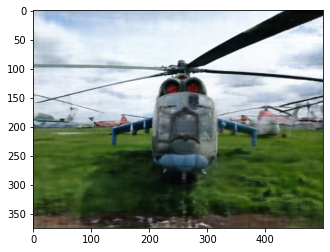

In [ ]:
down = 1
render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
test = render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

In [ ]:
import numpy as np
import imageio
import json
import random
import time
import pprint

images, poses, bds, render_poses, i_test = load_llff_data(args_create_nerf.datadir,
                                                          args_create_nerf.factor,
                                                          recenter=True,
                                                          bd_factor=.75,
                                                          spherify=args_create_nerf.spherify,
                                                          N_views=240)

H, W, focal = poses[0,:3,-1].astype(np.float32)

H = int(H)
W = int(W)
hwf = [H, W, focal]

images = images.astype(np.float32)
poses = poses.astype(np.float32)

if args_create_nerf.no_ndc:
    near = tf.reduce_min(bds) * .9
    far = tf.reduce_max(bds) * 1.
else:
    near = 0.
    far = 1.

_, render_kwargs_test, start, grad_vars, models = create_nerf(args_create_nerf)

bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

down = 1

frames = []
for i, c2w in enumerate(render_poses):
    if i%8==0: print(i)
    test = render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
    frames.append((255*np.clip(test[0],0,1)).astype(np.uint8))
    
print('done, saving')
# f = f'{args_create_nerf.basedir}/{args_create_nerf.expname}/video.mp4'
# imageio.mimwrite(f, frames, fps=30, quality=8)

Loaded image data (375, 500, 3, 25) [375.         500.         362.90451445]
Loaded (basedir, bds.min(), bds.max()):  /content/drive/MyDrive/Dataset/NeRF_Train 2.561864831080393 55.9432997509579
recentered (c2w.shape):  (3, 5)
[[ 1.0000000e+00  1.1716409e-09 -2.5613707e-08 -6.6757202e-08]
 [-1.1716407e-09  1.0000000e+00  7.1149184e-09 -2.3841857e-09]
 [ 2.5613705e-08 -7.1149184e-09  1.0000000e+00 -4.2915346e-08]]
Render_path_spiral with: N = 240
Render_path_spiral with: render_poses len =240
load_llff_data render_poses.shape = (240, 3, 5)
Data (poses.shape, images.shape, bds.shape):
(25, 3, 5) (25, 375, 500, 3) (25, 2)
HOLDOUT view is (i_test):  11
MODEL input_ch, input_ch_views, type(input_ch), type(input_ch_views), use_viewdirs 63 27 <class 'int'> <class 'int'> True
inputs.shape, inputs_pts.shape, inputs_views.shape:  (None, 90) (None, 63) (None, 27)
MODEL input_ch, input_ch_views, type(input_ch), type(input_ch_views), use_viewdirs 63 27 <class 'int'> <class 'int'> True
inputs.shape,

In [ ]:
import pickle 

f = f'{args_create_nerf.basedir}/{args_create_nerf.expname}'
file_name = f"{args_create_nerf.expname}-{args_create_nerf.N_views}.pkl"
open_file = open(os.path.join(f, file_name), "wb")
pickle.dump(frames, open_file)
open_file.close()

In [ ]:
len(frames)

240

In [ ]:
f = f'{args_create_nerf.basedir}/{args_create_nerf.expname}'
fps = 30
imageio.mimsave(os.path.join(f, f'{args_create_nerf.expname}_{fps}fps.gif'), frames, fps=fps)

In [ ]:
f

'/content/drive/MyDrive/Models/NeRF/logs/NeRF_Helicopter'

In [ ]:
down = 1 # trade off resolution+aliasing for render speed to make this video faster
frames = []
for i, c2w in enumerate(render_poses):
    if i%1==0: print(i)
    test = render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
    frames.append((255*np.clip(test[0],0,1)).astype(np.uint8))
    
print('done, saving')
f = f'{basedir}/{expname}/video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=8)

0
1
2


done, saving


In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import matplotlib.pyplot as plt
import numpy as np


def f(x, y, z):
    
    c2w = tf.convert_to_tensor([
        [1,0,0,x],
        [0,1,0,y],
        [0,0,1,z],
        [0,0,0,1],
    ], dtype=tf.float32)
    
    test = render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda : widgets.FloatSlider(
    value=0.,
    min=-1.,
    max=1.,
    step=.01,
)

names = ['x', 'y', 'z']
    
interactive_plot = interactive(f, **{n : sldr() for n in names})
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), FloatSlider(value…